# Demostration of ICAROS

## The purpose of this NB is: 

- Selecting events.

- Checking run conditions are normal.

- Computing XY correction maps.


## It is divided into three main sections:

1. __Section A:__ Map building with the automatic script that will be run by the shifter in Canfranc.

2. __Section B:__ Dissection of the script, function by function, to show the performance of each one.

2. __Section C:__ In case the map is produced, map checking.

In [1]:
import os
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [2]:
run_number = 0

In [3]:
folder_dst       = '/lustre/neu/data4/NEXT/NEXT100/MC/Background/FULLSIM/20200529/dorothea/output/'
dst_file       = '*.h5'
config_file    = '$ICARO/krcal/map_builder/config_NoChecks.conf'
ref_histo_file = '$ICARO/krcal/map_builder/reference_files/z_dst_LB_mean_ref.h5'

*Set input/output variables and configuration file*

In [21]:
from invisible_cities.core.configure         import configure

output_maps_file = '/data5/users/ausonandres/maps_analysis/Kr_lt/MC_maps_gonzalo'

file_bootstrap   = '/data5/users/ausonandres/maps_analysis/Kr_lt/MC_maps_gonzalo/map_NEXT100_bootstrap_492.h5'
map_file_out     = os.path.join(output_maps_file, 'map_NEXT100_fullsim_492.h5')
histo_file_out   = os.path.join(output_maps_file, 'histos_NEXT100_fullsim_492.h5')

print('Input dst: ', folder_dst + dst_file)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

ref_Z_histogram = dict(
                    ref_histo_file = ref_histo_file,
                    key_Z_histo    = 'histo_Z_dst') 

config = configure(f'maps {config_file}'.split())

config.update(dict(folder             = folder_dst     ,
                   file_in            = dst_file       ,
                   file_out_map       = map_file_out   ,
                   file_out_hists     = histo_file_out ,
                   ref_Z_histogram    = ref_Z_histogram,
                   run_number         = run_number     ,
                   file_bootstrap_map = file_bootstrap))

Input dst:  /lustre/neu/data4/NEXT/NEXT100/MC/Background/FULLSIM/20200529/dorothea/output/*.h5
Output map file:  /data5/users/ausonandres/maps_analysis/Kr_lt/MC_maps_gonzalo/map_NEXT100_fullsim_492.h5
Output histograms file:  /data5/users/ausonandres/maps_analysis/Kr_lt/MC_maps_gonzalo/histos_NEXT100_fullsim_492.h5


***

#### Imports

In [5]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import check_rate_and_hist
from krcal.map_builder.map_builder_functions  import selection_nS_mask_and_checking
from krcal.core.kr_types                      import type_of_signal
from krcal.map_builder.map_builder_functions  import check_Z_dst
from krcal.map_builder.map_builder_functions  import band_selector_and_check
from krcal.map_builder.map_builder_functions  import get_binning_auto
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.selection_functions           import selection_in_band

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections        import read_maps
from krcal.map_builder.map_builder_functions  import e0_xy_correction

from krcal.core.io_functions                  import write_complete_maps
from krcal.core.selection_functions           import get_time_series_df

from krcal.NB_utils   .xy_maps_functions     import draw_xy_maps
from krcal.core       .map_functions         import relative_errors
from krcal.core       .map_functions         import add_mapinfo

from invisible_cities.reco.corrections       import apply_all_correction

from krcal.NB_utils.plt_functions                import plot_s1histos
from krcal.NB_utils.plt_functions                import s1d_from_dst
from krcal.NB_utils.plt_functions                import plot_s2histos
from krcal.NB_utils.plt_functions                import s2d_from_dst
from krcal.NB_utils.plt_functions                import plot_selection_in_band

from krcal.core.core_functions                import time_delta_from_time
from krcal.core.fitmap_functions              import time_fcs_df
from krcal.NB_utils.plt_functions             import plot_time_fcs

from invisible_cities.core.configure          import configure

#### Loading data (only events inside detector chamber; i.e. R<=492)

In [24]:
config_values  = config.as_namespace
quality_ranges = config_values.quality_ranges
quality_ranges['r_max'] = 492
print(' Only events with R smaller than {}'.format(quality_ranges['r_max']))
inputs = load_data(input_path         = folder_dst                       ,
                   input_dsts         = dst_file                         ,
                   file_bootstrap_map = file_bootstrap                   ,
                   ref_histo_file     = ref_Z_histogram['ref_histo_file'],
                   key_Z_histo        = ref_Z_histogram['key_Z_histo']   ,
                   quality_ranges     = quality_ranges                   )

dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]

 Only events with R smaller than 492


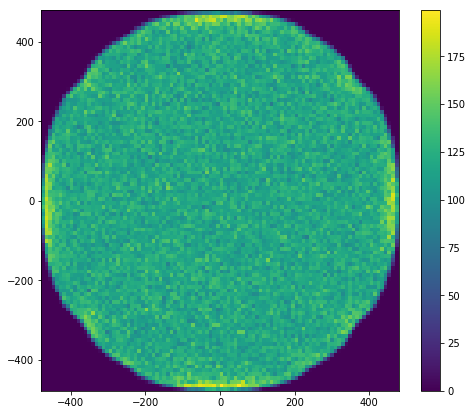

In [25]:
plt.figure(figsize=(8, 7))
plt.hist2d(dst.X, dst.Y, 100);
plt.colorbar();

### 1st check: rate before selection

## Event selection

### nS1 selection (2nd check)

In [26]:
#nS1_eff_interval = (config_values.nS1_eff_min, config_values.nS1_eff_max)
#with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
#    mask_s1 = selection_nS_mask_and_checking(dst        = dst               ,
#                                             column     = type_of_signal.nS1,
#                                             interval   = nS1_eff_interval  ,
#                                             output_f   = store_hist        ,
#                                             input_mask = None              ,
#                                             nbins_hist = 10                ,
#                                             range_hist = (0,10)            ,
#                                             norm       = True              )

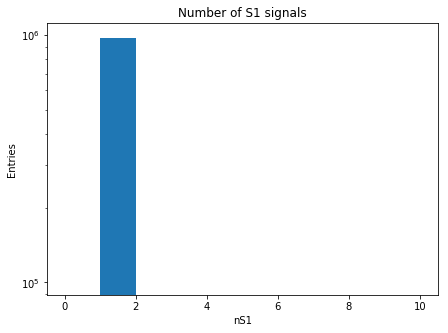

In [27]:
plt.figure(figsize=(7,5));
plt.hist(dst.drop_duplicates(subset='event').nS1, 10, (0, 10))
plt.yscale('log');
plt.xlabel('nS1');
plt.ylabel('Entries');
plt.title('Number of S1 signals');

In [28]:
mask_s1 = dst.nS1==1

In [29]:
eff = dst[mask_s1].event.nunique()/dst.event.nunique()
print('S1 selection efficiency: ', eff*100, '%')

S1 selection efficiency:  100.0 %


*Some other S1 plots:*

/home/ausonandres/ICAROS/krcal/core/stat_functions.py:29: UserWarning: warning, empty slice of x = [200000. 200100. 200025. ... 200125. 200150. 200150.] in range = (0, 600)
  warnings.warn(f'warning, empty slice of x = {x} in range = {range_}')


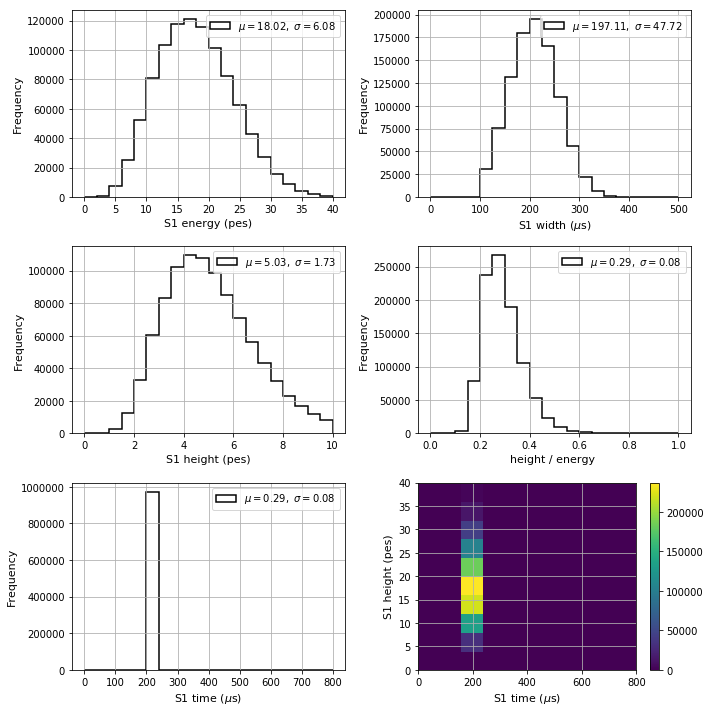

In [30]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### nS2 selection (3rd chech)

In [31]:
nS2_eff_interval = (config_values.nS2_eff_min, config_values.nS2_eff_max)
with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
    mask_s2 = selection_nS_mask_and_checking(dst        = dst               ,
                                             column     = type_of_signal.nS2,
                                             interval   = nS2_eff_interval  ,
                                             output_f   = store_hist        ,
                                             input_mask = mask_s1           ,
                                             nbins_hist = 10                ,
                                             range_hist = (0,10)            ,
                                             norm       = True              )

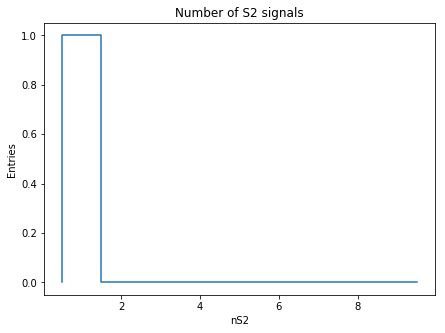

In [32]:
s2_hist = pd.read_hdf(histo_file_out, key='nS2')
plt.figure(figsize=(7,5));
plt.step(s2_hist.magnitude, s2_hist.entries, where='pre');
plt.xlabel('nS2');
plt.ylabel('Entries');
plt.title('Number of S2 signals');

In [33]:
eff = dst[mask_s2].event.nunique()/dst[mask_s1].event.nunique()
print('S2 selection efficiency: ', eff*100, '%')

S2 selection efficiency:  99.99845865812831 %


*Some other S2 plots:*

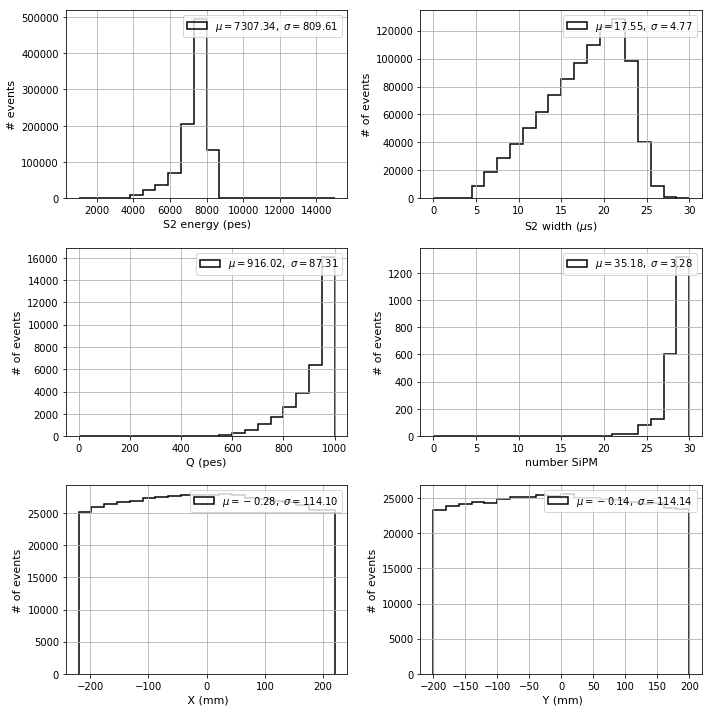

In [34]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### 4th check: Z distribution of events is correct

In [35]:
check_Z_dst(Z_vect   = dst[mask_s2].Z            ,
            ref_hist = ref_histos.Z_dist_hist    ,
            n_sigmas = config_values.nsigmas_Zdst)

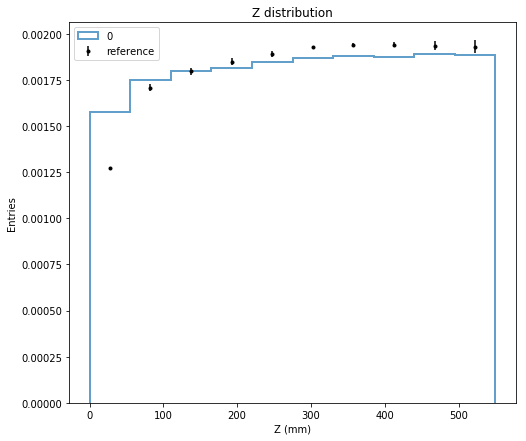

In [36]:
plt.figure(figsize=(8,7));
plt.title('Z distribution');
plt.hist(dst[mask_s2].Z, 10, (0, 550), density=1, histtype='step', alpha=0.7, linewidth=2, label=run_number);
plt.errorbar(ref_histos.Z_dist_hist.bin_centres, ref_histos.Z_dist_hist.bin_entries, yerr=ref_histos.Z_dist_hist.err_bin_entries, fmt='.k', label='reference');
plt.legend();
plt.ylabel('Entries');
plt.xlabel('Z (mm)');

*And XY distribution:*

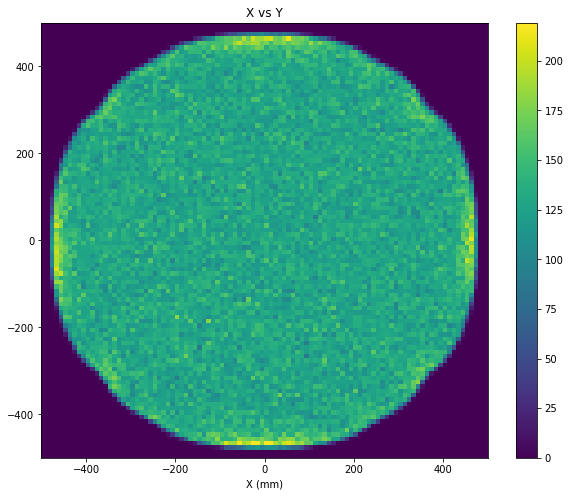

In [37]:
plt.figure(figsize=(10,8))
plt.hist2d(dst[mask_s2].X, dst[mask_s2].Y, 100, [(-500,500),(-500,500)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

### Time stamps

### Band selection (5th check)

*Geom. correction with bootstrap map is applied before*:

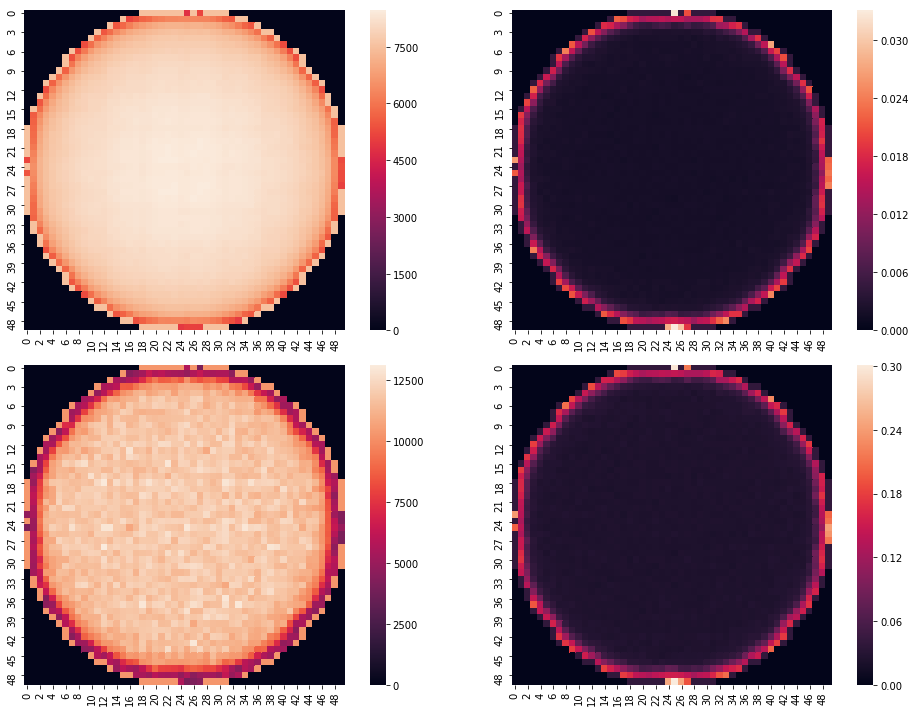

In [38]:
draw_xy_maps(bootstrapmap)

*Applying geometrical correction:*

In [39]:
geom_corr = e0_xy_correction(bootstrapmap)
corr = geom_corr(dst[mask_s2].X, dst[mask_s2].Y)

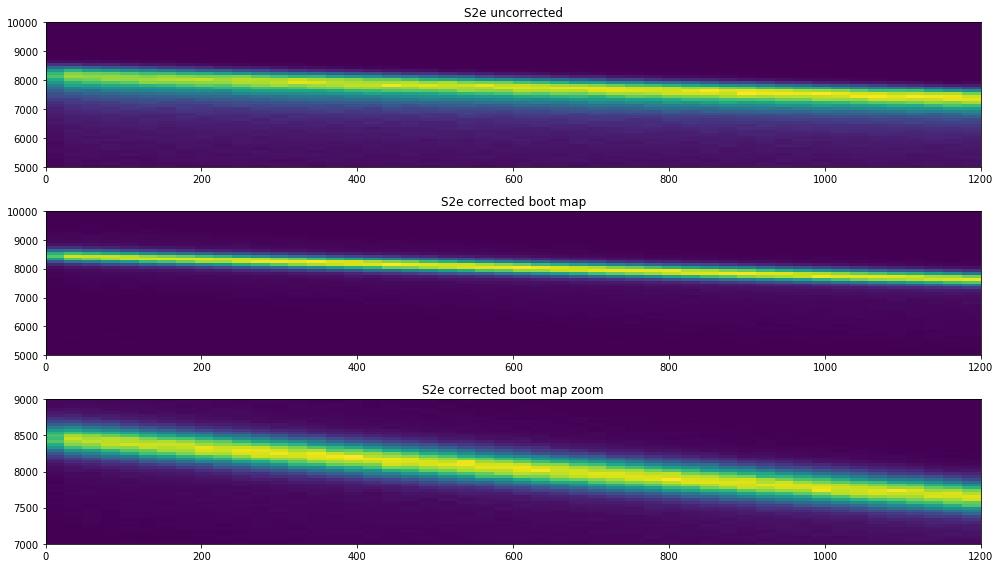

In [40]:
fig = plt.figure(figsize=(14,8))
plt.subplot(3, 1, 1)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, range=[[0,1200],[5000, 10000]]);

plt.title('S2e uncorrected')
plt.subplot(3, 1, 2)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,1200],[5000, 10000]])
plt.title('S2e corrected boot map')

plt.subplot(3, 1, 3)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,1200],[7000, 9000]])
plt.title('S2e corrected boot map zoom')
plt.tight_layout()

*Selection:*

In [41]:
config['band_sel_params']

{'range_Z': (10, 550),
 'range_E': (10000.0, 14000.0),
 'nbins_z': 50,
 'nbins_e': 50,
 'nsigma_sel': 3.5,
 'eff_min': 0.0,
 'eff_max': 1.0}

In [42]:
band_sel_params_new = config['band_sel_params']
band_sel_params_new['range_Z'] = (50, 1150)
band_sel_params_new['range_E'] = (7000, 9000)
#band_sel_params_new['range_Z'] = (10, 510)
band_sel_params_new['nsigma_sel'] = 3.5
#config.update(dict(map_params = map_params_new))

In [43]:
band_sel_params_new

{'range_Z': (50, 1150),
 'range_E': (7000, 9000),
 'nbins_z': 50,
 'nbins_e': 50,
 'nsigma_sel': 3.5,
 'eff_min': 0.0,
 'eff_max': 1.0}

In [44]:
band_sel_params = config_values.band_sel_params
mask_band = band_selector_and_check(dst        = dst         ,
                                    boot_map   = bootstrapmap,
                                    input_mask = mask_s2     ,
                                    **band_sel_params_new    )

/home/ausonandres/ICAROS/krcal/core/fit_functions.py:52: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/home/ausonandres/ICAROS/krcal/core/fit_functions.py:52: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


In [45]:
eff = dst[mask_band].event.nunique()/dst[mask_s2].event.nunique()
print('Band selection efficiency: ', eff*100, '%')

Band selection efficiency:  93.93873379896276 %


In [46]:
emaps = e0_xy_correction(bootstrapmap)
E0 = dst[mask_s2].S2e.values * emaps(dst[mask_s2].X.values, dst[mask_s2].Y.values)

sel_krband = np.zeros_like(mask_s2)
sel_krband[mask_s2], fpl, fph, hp, pp = selection_in_band(dst[mask_s2].Z,
                                                          E0,
                                                          range_z = band_sel_params_new['range_Z'],
                                                          range_e = band_sel_params_new['range_E'],
                                                          nbins_z = band_sel_params_new['nbins_z'],
                                                          nbins_e = band_sel_params_new['nbins_e'],
                                                          nsigma  = band_sel_params_new['nsigma_sel'])

/home/ausonandres/ICAROS/krcal/core/fit_functions.py:52: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/home/ausonandres/ICAROS/krcal/core/fit_functions.py:52: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


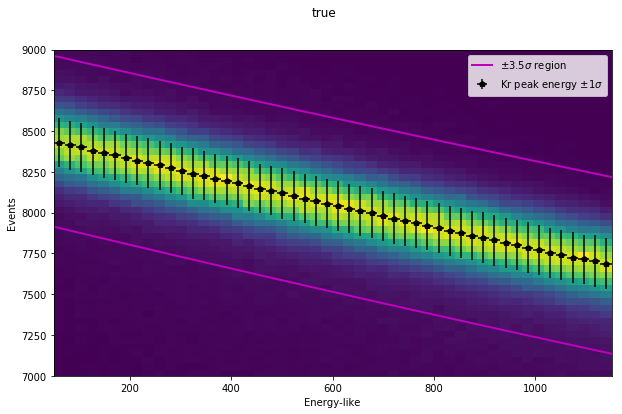

In [47]:
plot_selection_in_band(fpl, fph, hp, pp, nsigma = band_sel_params_new['nsigma_sel'])

*Krypton peak after geometrical correction:*

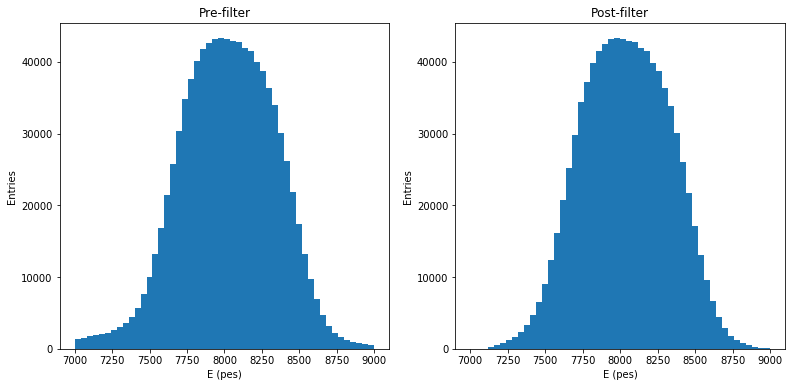

In [48]:
corr_band = geom_corr(dst[mask_band].X, dst[mask_band].Y)
fig = plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.hist(dst[mask_s2].S2e*corr,  bins = 50, range =(7000, 9000))
plt.title('Pre-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.subplot(1, 2, 2)
plt.hist(dst[mask_band].S2e*corr_band,  bins = 50, range =(7000, 9000))
plt.title('Post-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');

In [49]:
sel_dst = dst[mask_band]

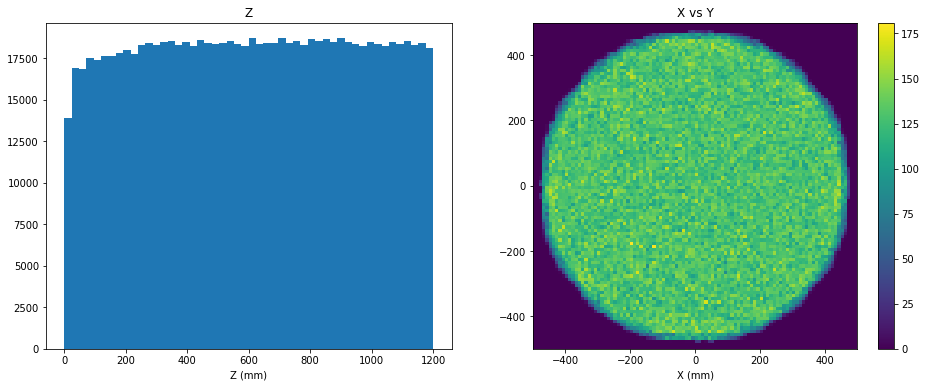

In [50]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(sel_dst.Z, bins = 50, range =(0,1200))
plt.title('Z')
plt.xlabel('Z (mm)');
plt.subplot(1,2,2);
plt.hist2d(sel_dst.X, sel_dst.Y, 100, [(-500,500),(-500,500)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

If all selection cuts and checks are passed successfully, it is time to create the correction map.

## Map production

#### Selection of number of XY bins

In [51]:
thr_evts_for_sel_map_bins = config_values.thr_evts_for_sel_map_bins
default_n_bins            = config_values.default_n_bins

- If the number of evts is greater than 1e6 -> 100x100 map
- If the number of evts is lower than 1e6 -> 50x50 map

In [52]:
number_of_bins = get_binning_auto(nevt_sel                = sel_dst.event.nunique()  ,
                                  thr_events_for_map_bins = thr_evts_for_sel_map_bins,
                                  n_bins                  = default_n_bins           )
print('Number of XY bins: ', number_of_bins, '(', sel_dst.event.nunique(), 'events)')

Number of XY bins:  50 ( 914177 events)


### Map computation

In [53]:
map_params = config_values.map_params

In [54]:
map_params

{'nbins_z': 15,
 'nbins_e': 25,
 'z_range': (10, 550),
 'e_range': (2000, 18000),
 'chi2_range': (0, 10),
 'lt_range': (1000, 15000),
 'nmin': 100,
 'maxFailed': 600,
 'r_max': 200,
 'r_fid': 100,
 'nStimeprofile': 1800,
 'x_range': (-200, 200),
 'y_range': (-200, 200)}

In [55]:
map_params_new = config['map_params']
map_params_new['nbins_z']   = (30)
map_params_new['z_range']   = (20, 1150)
map_params_new['e_range']    = (6000, 9000)
map_params_new['lt_range']   = (5000, 20000)
map_params_new['chi2_range'] = (0, 5)
map_params_new['r_max'] = 492
map_params_new['x_range'] = (-492, 492)
map_params_new['y_range'] = (-492, 492)
map_params_new['maxFailed'] = 800

In [56]:
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [57]:
maps = calculate_map(dst        = sel_dst                 ,
                     XYbins     = (number_of_bins         ,
                                   number_of_bins)        ,
                     nbins_z    = map_params_new['nbins_z']   ,
                     nbins_e    = map_params_new['nbins_e']   ,
                     z_range    = map_params_new['z_range']   ,
                     e_range    = map_params_new['e_range']   ,
                     chi2_range = map_params_new['chi2_range'],
                     lt_range   = map_params_new['lt_range']  ,
                     fit_type   = FitType.unbined         ,
                     nmin       = map_params_new['nmin']      ,
                     x_range    = map_params_new['x_range']   ,
                     y_range    = map_params_new['y_range']   )

### Last check: number of failed fits

In [58]:
maxFailed = map_params['maxFailed']
r_max     = map_params['r_max']

check_failed_fits(maps      = maps          ,
                  maxFailed = maxFailed     ,
                  nbins     = number_of_bins,
                  rmax      = r_max         ,
                  rfid      = r_max         )

    Number of failing fits: 124


#### chi2 regularization and compute relative error maps, instead of absolute error.

In [59]:
regularized_maps = regularize_map(maps    = maps                    ,
                                  x2range = map_params['chi2_range'])

regularized_maps = relative_errors(am = regularized_maps)

Now, the outer bins are replaced by nans:

In [60]:
regularized_maps = remove_peripheral(map   = regularized_maps,
                                     nbins = number_of_bins  ,
                                     rmax  = r_max           ,
                                     rfid  = r_max           )

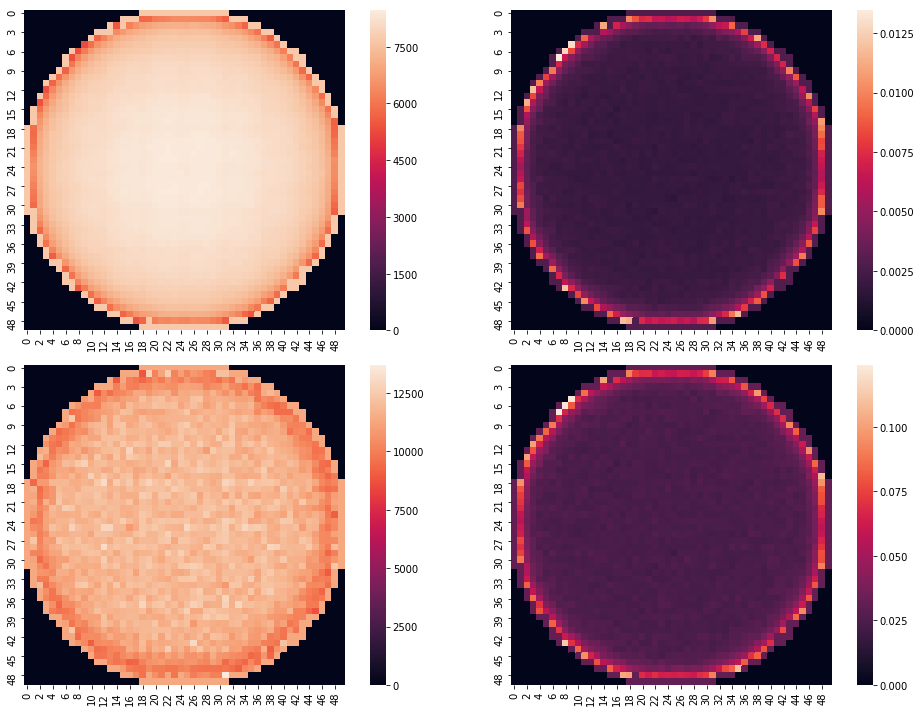

In [61]:
draw_xy_maps(regularized_maps,
             figsize=(14,10))

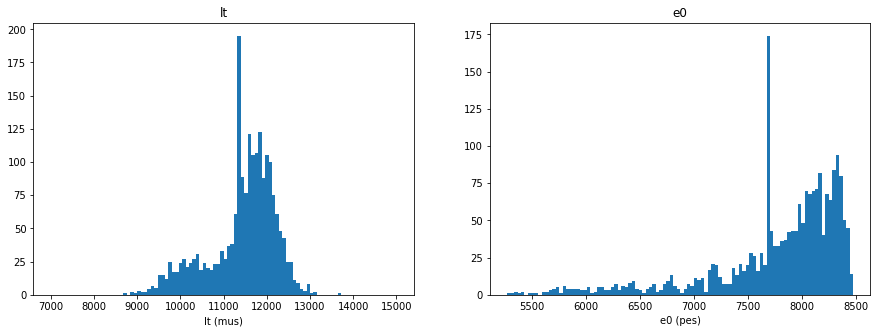

In [62]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(regularized_maps.lt.values.flatten(), 100, (7000, 15000));
plt.title('lt')
plt.xlabel('lt (mus)');
plt.subplot(122)
plt.hist(regularized_maps.e0.values.flatten(), 100);
plt.title('e0')
plt.xlabel('e0 (pes)');

#### Mapinfo table is added

In [63]:
maps = add_mapinfo(asm        = regularized_maps     ,
                   xr         = map_params['x_range'],
                   yr         = map_params['y_range'],
                   nx         = number_of_bins       ,
                   ny         = number_of_bins       ,
                   run_number = run_number           )
print(maps.mapinfo)

xmin         -492
xmax          492
ymin         -492
ymax          492
nx             50
ny             50
run_number      0
dtype: int64


#### Temporal evolution table is added

In [46]:
#r_fid         = map_params['r_fid']
#nStimeprofile = map_params['nStimeprofile']
#add_krevol(maps          = maps                 ,
#           dst           = sel_dst              ,
#           r_fid         = r_fid                ,
#           nStimeprofile = nStimeprofile        ,
#           x_range       = map_params['x_range'],
#           y_range       = map_params['y_range'],
#           XYbins        = (number_of_bins      ,
#                            number_of_bins     ))
#temp = maps.t_evol

In [47]:
#plt.figure(figsize=(16, 20));
#plt.subplot(3,2,1);
#plt.title('e0');
#plt.errorbar(temp.ts, temp.e0, temp.e0u, fmt='.', linestyle='-');
#plt.subplot(3,2,2);
#plt.title('lt');
#plt.errorbar(temp.ts, temp['lt'], temp['ltu'], fmt='.', linestyle='-');
#plt.subplot(3,2,3);
#plt.title('dv');
#plt.ylim(0.907, 0.920);
#plt.errorbar(temp.ts, temp.dv, temp.dvu, fmt='.', linestyle='-');
#plt.subplot(3,2,4);
#plt.title('s1e');
#plt.errorbar(temp.ts, temp.s1e, temp.s1eu, fmt='.', linestyle='-');
#plt.subplot(3,2,5);
#plt.title('s2e');
#plt.errorbar(temp.ts, temp.s2e, temp.s2eu, fmt='.', linestyle='-');
#plt.subplot(3,2,6);
#plt.title('Nsipm');
#plt.errorbar(temp.ts, temp.Nsipm, temp.Nsipmu, fmt='.', linestyle='-');

### Writing final map

In [64]:
write_complete_maps(asm      = maps        ,
                    filename = map_file_out)

*****

# Section C: Checking map <a id='SectionC'></a>


In [65]:
import matplotlib.pyplot as plt
import pandas as pd
from invisible_cities.reco.corrections       import read_maps
from invisible_cities.reco.corrections       import apply_all_correction
from krcal.NB_utils  .xy_maps_functions      import draw_xy_maps

from krcal.NB_utils.plt_functions             import h1, h2
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy
from krcal.NB_utils.plt_energy_functions      import resolution_r_z, plot_resolution_r_z

from krcal.map_builder.map_builder_functions  import e0_xy_correction
from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import apply_cuts
from krcal.map_builder.map_builder_functions  import type_of_signal

### Opening map

In [66]:
try:
    final_map = read_maps(map_file_out)
except FileNotFoundError:
    print('Please run Section A or B. If you have already done it, the dst is not good enough to produce a map :(')

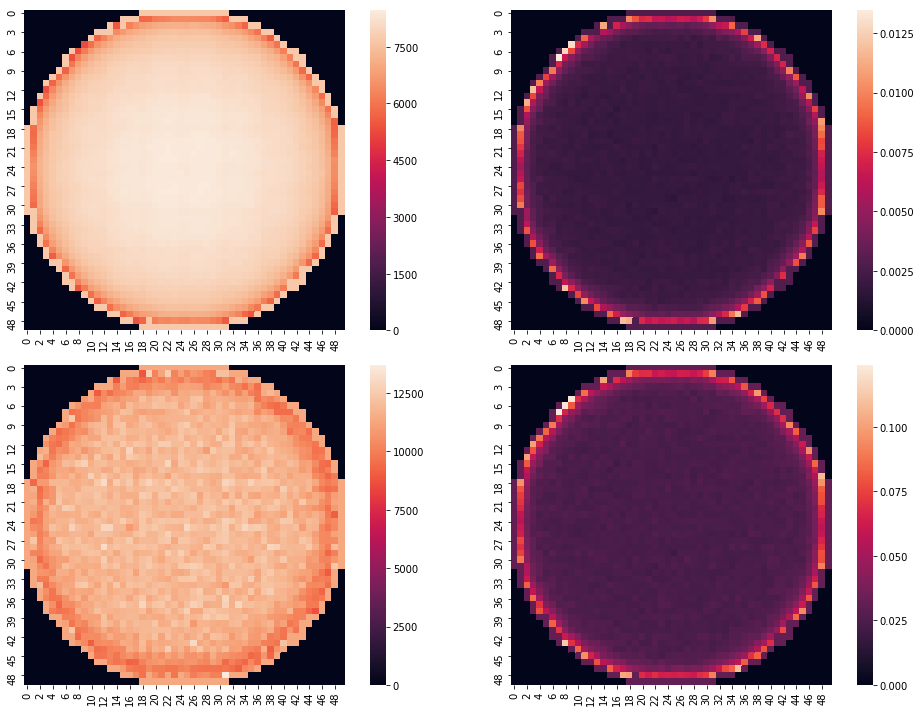

In [67]:
draw_xy_maps(final_map,
             figsize=(14,10))

In [68]:
final_map.mapinfo

xmin         -492
xmax          492
ymin         -492
ymax          492
nx             50
ny             50
run_number      0
dtype: int64

### Opening and selecting dst (only if section B is not run)

In [69]:
try :
    sel_dst;
except NameError:
    config_values = config.as_namespace
    
    inputs = load_data(input_path         = folder_dst                  ,
                       input_dsts         = dst_file                    ,
                       file_bootstrap_map = file_bootstrap              ,
                       quality_ranges     = config_values.quality_ranges,
                       **config_values.ref_Z_histogram                  )

    dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]
    
    with pd.HDFStore(histo_file_out, "r+", complib=str("zlib"), complevel=4) as store_hist:
        sel_dst = apply_cuts(dst              = dst                           ,
                             S1_signal        = type_of_signal.nS1            ,
                             nS1_eff_interval = (config_values.nS1_eff_min    ,
                                                 config_values.nS1_eff_max)   ,
                             store_hist_s1    = store_hist                    ,
                             ns1_histo_params = config_values.ns1_histo_params,
                             S2_signal        = type_of_signal.nS2            ,
                             nS2_eff_interval = (config_values.nS2_eff_min    ,
                                                 config_values.nS2_eff_max)   ,
                             store_hist_s2    = store_hist                    ,
                             ns2_histo_params = config_values.ns2_histo_params,
                             nsigmas_Zdst     = config_values.nsigmas_Zdst    ,
                             ref_Z_histo      = ref_histos.
                                                    Z_dist_hist               ,
                             bootstrapmap     = bootstrapmap                  ,
                             band_sel_params  = config_values.band_sel_params )

### Applying corrections to the selected dst

In [70]:
sel_dst = sel_dst[sel_dst.R<450]

In [71]:
geom_corr = e0_xy_correction(final_map)
total_correction = apply_all_correction(final_map, apply_temp=False)

corr_geo = geom_corr(sel_dst.X, sel_dst.Y)
corr_tot = total_correction(sel_dst.X, sel_dst.Y, sel_dst.Z, sel_dst.time)

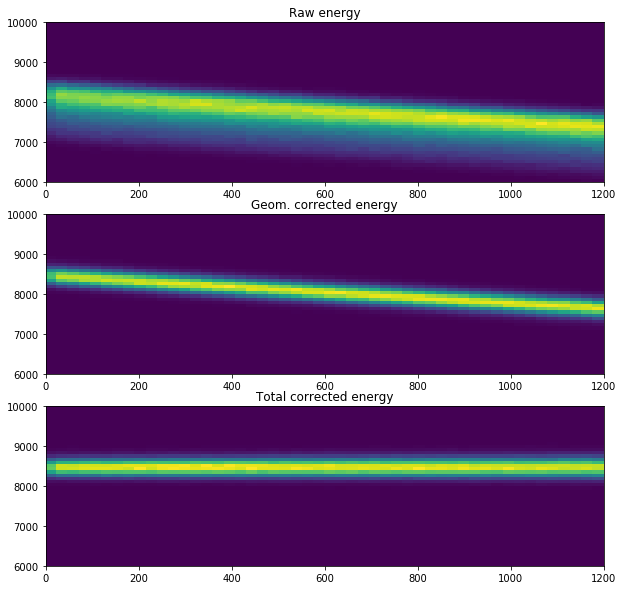

In [72]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, [(0,1200),(6000,10000)])
plt.title('Raw energy');
plt.subplot(3, 1, 2)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_geo, 50, [(0,1200),(6000,10000)])
plt.title('Geom. corrected energy');
plt.subplot(3, 1, 3)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_tot, 50, [(0,1200),(6000,10000)])
plt.title('Total corrected energy');

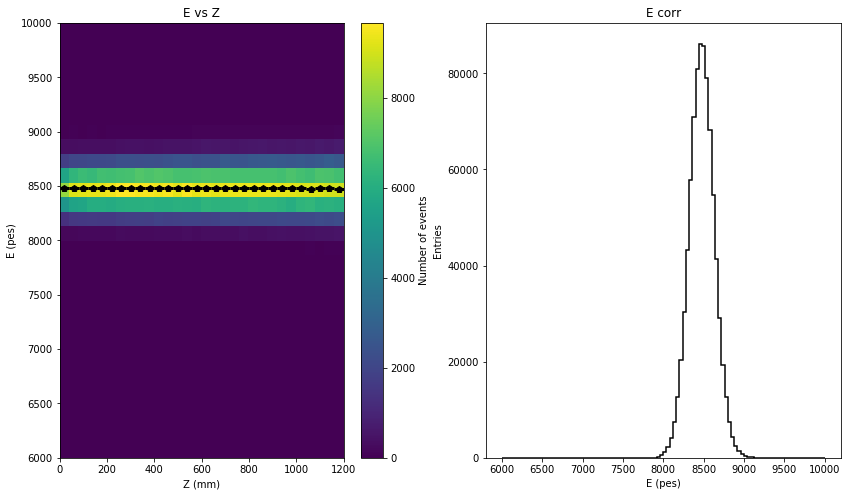

In [73]:
e_range = (6000,10000)
zrange = (0,1200)
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

nevt = h2(sel_dst.Z, sel_dst.S2e*corr_tot, 30, 30, zrange, e_range, profile=True)
plt.xlabel('Z (mm)');
plt.ylabel('E (pes)');
plt.title('E vs Z');

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(sel_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.title('E corr');

  Fit was valid = True
 Emu       = 8478.08855663311 +-0.17130773700534344 
 E sigma   = 153.21512302624262 +-0.13069066625218187 
 chi2    = 13.175916638885573 
 sigma E/E (FWHM)     (%) =4.246895237134187
 sigma E/E (FWHM) Qbb (%) =0.5484948282642176 


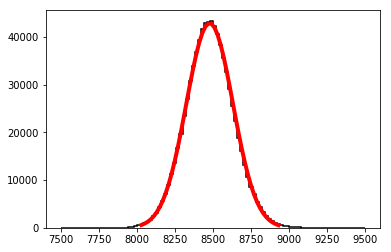

In [74]:
fc = fit_energy(sel_dst.S2e*corr_tot, nbins=100, range=(7500, 9500))
plot_fit_energy(fc)
print_fit_energy(fc)

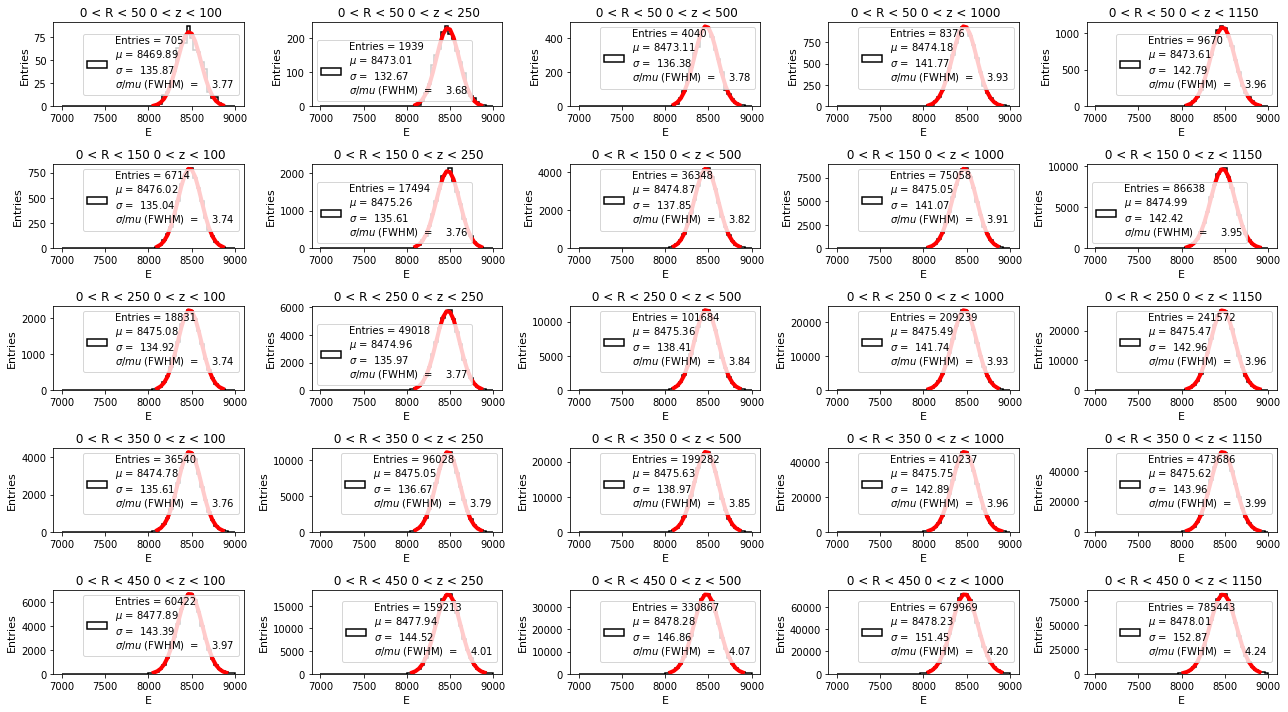

In [75]:
Ri = (50,150,250, 350, 450)
Zi = (100, 250, 500, 1000, 1150)

FC, FCE = resolution_r_z(Ri, Zi, sel_dst.R, sel_dst.Z, sel_dst.S2e*corr_tot,
                    enbins = 50,
                    erange = (7000,9000),
                    ixy = (5,5),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

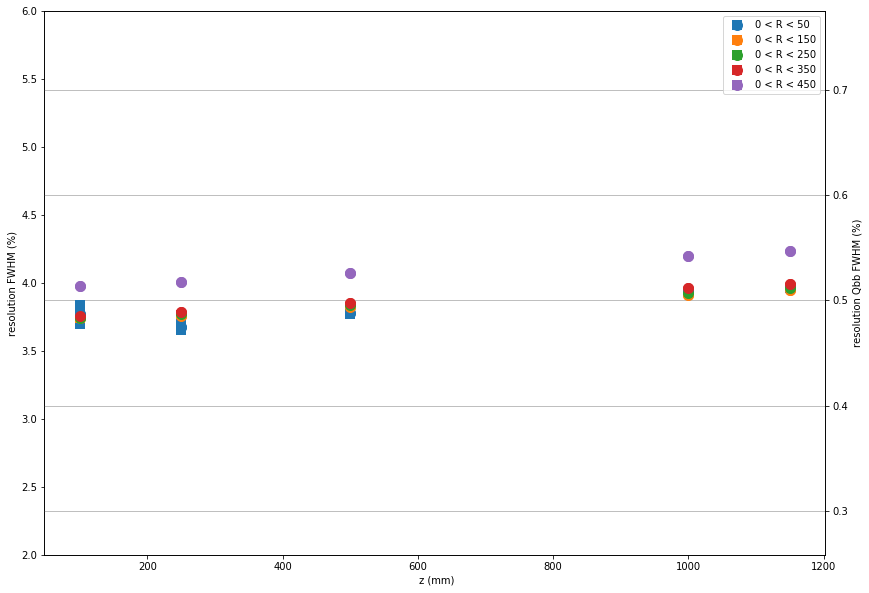

In [76]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(2,6))